# **Setup**

## Code representation - #TO DO

In [0]:
# ALTERNATIVE 1 : # https://www.programmersought.com/article/26078136414/

# ALTERNATIVE 2 :
# #%% [code]
# !pip install --q pylint
# !pyreverse -o png datetime

## Non-native libs installation

In [0]:
!pip install lime > /dev/null
!pip install scikit-image > /dev/null
!pip install Pillow==9.0.0 > /dev/null

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


## Import

In [0]:
import pandas as pd
import numpy as np
import json
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display
from tensorflow.math import reduce_max
from tensorflow.keras.models import Model
from tensorflow import GradientTape, reduce_mean, newaxis
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import seaborn as sns
from os.path import exists
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.optimizers import Adam, SGD,Adadelta,RMSprop,Adagrad, Adamax,Nadam, Ftrl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from json import load
from time import time
from mlflow.keras import autolog
from mlflow import start_run,end_run
from matplotlib.cm import get_cmap

In [0]:
experiment_id = '3885035616275106'

## Prepare db

In [0]:
prob_definitions = ['A1',
                    'A2',
                    'A3']

In [0]:
lbls_dict = {'A1':{1:'Eletromecânico',
                  11:'Eletrônico'},
             'A2':{1:'Energia',
                  3:'Energia Reativa/ativa'},
             'A3':{1:'Monofásico',
                  2:'Bifásico',
                  3:'Trifásico'}
            }

In [0]:
paths = {'root' : '/dbfs/mnt/grupo05/'}
paths.update({
          'data' : paths['root'] +'data/',
          'results' : paths['root']+'results/',
          'bin' : paths['root']+'bin/'
})

In [0]:
db = pd.read_pickle(paths['results']+'db.pkl')

In [0]:
prob_paths = [paths['results'] +prob_def+'/' for prob_def in prob_definitions]

In [0]:
def load_params(params_path):
  with open(params_path) as f:
    params = load(f)
  return params

In [0]:
def lbl_enc(serie_std):
  if serie_std.drop_duplicates().values.shape[0]>2:
    lb = LabelEncoder()
  else:
    lb = LabelBinarizer()
  lb = lb.fit_transform(serie_std)
  serie_enc = pd.Series(list(to_categorical(lb)),index=serie_std.index,name='lbls_enc')
  return serie_enc

In [0]:
dbs = {}
test_size = 0.5
for prob_def in prob_definitions:
    lbls = getattr(db,prob_def)
    lbls_enc = lbl_enc(lbls)
    lbls_names = lbls.map(lbls_dict[prob_def])
    lbls_names.name = 'lbls_names'
    lbls = pd.concat([lbls,lbls_enc,lbls_names],axis=1)
    lbls = lbls.reset_index()
    data = db.imgs_norm.reset_index()
    X_train, test,y_train,test_lbl = train_test_split(data,lbls, test_size=test_size)
    X_val, X_test, y_val, y_test = train_test_split(test,test_lbl, test_size=0.5)
    print(X_train.shape, X_test.shape,X_val.shape, y_train.shape, y_test.shape, y_val.shape)
    dbs [prob_def] = [X_train, X_test,X_val, y_train, y_test, y_val]

(431, 2) (216, 2) (215, 2) (431, 4) (216, 4) (215, 4)
(431, 2) (216, 2) (215, 2) (431, 4) (216, 4) (215, 4)
(431, 2) (216, 2) (215, 2) (431, 4) (216, 4) (215, 4)


## Hyperparameters

In [0]:
loss = 'bin_cross'
opt = 'nadam'
#Available optimizers
# SGD  acc zerada na classe minoritaria(testado por 2x)
# RMSprop
# Adam
# Adadelta
# Adagrad
# Adamax
# Nadam
# Ftrl

EPOCHS = 80# de 40 pra 50 e pra 80 houve smp melhora na acc e nao houve parada por early stoping(patience aumentada tb) ESPERADO
BS = 20# aumento BS conduziu a maiores acc e menor instabilidade na performance do treino ESPERADO https://openreview.net/pdf?id=B1Yy1BxCZ
INIT_LR = 1e-3# aumento pra 10-5 conduziu a acc zero e instabilidade na performance do treino (dataset mt peq) INESPERADO 
fold = 'kf_'
patience = int(EPOCHS/5)#https://link.springer.com/chapter/10.1007/978-3-642-35289-8_5#:~:text=Validation%20can%20be%20used%20to,(%E2%80%9Cearly%20stopping%E2%80%9D).

# Create dictionary with parameters for each problem : A1 should have the smallest patience
train_params = {'loss':loss,
                'opt':opt,
                'EPOCHS':EPOCHS,
                'BS':BS,
                'INIT_LR':INIT_LR,
                # 'k':5,
                'patience':patience}
# train_params.update({'fold':fold+str(train_params['k'])})
lst_train_params = '_'.join(map(str,list(itertools.chain(*train_params.items()))))   
train_params_paths = []
for prob_path,prob_def,db in zip(prob_paths,prob_definitions,dbs):
    params = train_params
    lbls_num = dbs[db][3].lbls_enc.iloc[0].shape[0]
    if lbls_num>2:
        params['loss'] = 'categorical_crossentropy'
    params['prob_path'] = prob_path
    params['prob_def'] = prob_def
    train_params_path = prob_path+'train_params_'+lst_train_params+'.json'
    train_params_paths.append(train_params_path)
    with open(train_params_path, 'w+') as f:
        json.dump(params, f)

# **Image Classification**

## The proposed network

"In detail to the VGG-16 architecture we added the following layers (as shown by the network depicted in Figure 1):



*   AveragePooling2D: it performs average pooling operation. This layer involves computing the average for each patch of the feature map under analysis. This means that each 2x2 square of the feature map is down sampled to the average value;

*   Flatten: the aim of this layer is to flat the input. It is a utility layer, it flats an input, for instance a rows x columns matrix, to a simple vector output of rows * columns shape. Flattening transforms a two- dimensional matrix of features into a vector that can be fed into a fully connected neural network classifier.

*   Dense: is the regular deeply connected neural network layer. The purpose of the layer is to transform the data. It is most common and frequently used layer. It this case this case layer reduces the vector of height 512 to a vector of 64 elements;

*   Dropout: this layer basically works in the following way i.e., by ran- domly select neurons not considered in the training. The aim of this layer is to ameliorate generalization in fact, we are coercing the network to train the same high-level concept by exploiting different neurons. We chose to ignore the 50% of neurons. Clearly, we are aware that typi- cally exploiting this layer this we can reach worse performances, but we want to generate a model less sensitive to data variations;

*   Dense: the last dense layer is aimed to reduce the vector of height 64 to a vector of 2 elements (i.e., the two classes to predict)."

In [0]:
#################################        DATA AUGMENTATION       #################################


# initialize the training data augmentation object
def set_data_augmentation():
    gen = ImageDataGenerator(
        rotation_range=15,
#         brightness_range=[1.0,1.5],
#         contrast_stretching=True,
#         zoom_range=0.2,
        fill_mode="nearest")
    return gen


###############################        THE PROPOSED NETWORK       ###############################


def set_network(dim,outs_num):
    
    baseModel = VGG16(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(*dim, 3)))
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(outs_num, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    for layer in baseModel.layers:
        layer.trainable = False
        
        # # adding regularization
        # regularizer = tf.keras.regularizers.l2(penalty)

        # for layer in base_model.layers:
        #     for attr in ['kernel_regularizer']:
        #         if hasattr(layer, attr):
        #           setattr(layer, attr, regularizer)        
        
        
    return model

## Run trainining

In [0]:
# def contrast_stretching(x):
#     if np.random.random() < 0.5: #####
#             p2, p98 = np.percentile(x, (2, 98)) #####
#             x = exposure.rescale_intensity(x, in_range=(p2, p98))
            

In [0]:
#####################################        TRAIN       #####################################


# https://www.researchgate.net/post/How-many-images-does-Imagedatagenerator-generate-in-deep-learning
# For example, if you have 1000 images in your dataset and the batch size is defined as 10. Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.
# An iteration is defined as steps per epoch i.e. the total number of samples / batch_size.
# In above case, in each epoch of training there will be 100 iterations.

# https://datascience.stackexchange.com/questions/89313/how-many-images-are-generated-when-imagedatagenerator-is-used-and-when-data-aug
# In one epoch - It's the number of images in your Directory or the DataFrame 
# In case of a custom Generator. It will be batch_size * steps_per_epoch


def train(model, gen, parameters, data):

    # k = parameters['k']
    EPOCHS = parameters['EPOCHS']
    BS = parameters['BS']
    INIT_LR = parameters['INIT_LR']

    # fold_dict = { 'kf_5' : KFold(n_splits = k), 
    #               'skf_5' : StratifiedKFold(n_splits = k, random_state = 7, shuffle = True)} 
    opt_dict = {'adam' : Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS),
                'sgd' : SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS),
               'rmsprop' : RMSprop(lr=INIT_LR, decay=INIT_LR / EPOCHS),
               'adadelta' : Adadelta(lr=INIT_LR, decay=INIT_LR / EPOCHS),
               'adagrad' : Adagrad(lr=INIT_LR, decay=INIT_LR / EPOCHS), 
               'adamax': Adamax(lr=INIT_LR, decay=INIT_LR / EPOCHS),
               'nadam' : Nadam(lr=INIT_LR, decay=INIT_LR / EPOCHS), 
               'ftrl' : Ftrl(lr=INIT_LR, decay=INIT_LR / EPOCHS)}
    loss_funcs = {'bin_cross':'binary_crossentropy',
                 'categorical_crossentropy':'categorical_crossentropy'}

    
    patience = parameters['patience']
    loss = loss_funcs[parameters['loss']]
    opt = opt_dict[parameters['opt']]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    train_data = np.array(data[0].imgs_norm.to_list(), dtype="float")
    train_data_lbl = np.array(data[3].lbls_enc.to_list(), dtype="float")
    val_data = np.array(data[2].imgs_norm.to_list(), dtype="float")
    val_data_lbl = np.array(data[5].lbls_enc.to_list(), dtype="float")

    models = {}
    Hs = {}
    model.compile(loss = loss, 
                optimizer = opt,
                metrics = ["accuracy"])
    with start_run(experiment_id = experiment_id, run_name = 'ground_zero') as run:
      autolog()
      print(train_data_lbl.shape)
      H = model.fit_generator(
                gen.flow(train_data,train_data_lbl,batch_size=BS),
                validation_data=(val_data, val_data_lbl),
                epochs=EPOCHS, callbacks=[es])
        

      end_run()
    return model,H

In [0]:
def image_classification(problem, params_path,data):
    
    parameters = load_params(params_path)
    img_dim = data[0].imgs_norm.iloc[0].shape[:2]
    lbls_num = data[3].lbls_enc.iloc[0].shape[0]
    EPOCHS = parameters['EPOCHS']

    data_gen = set_data_augmentation()
    network_model = set_network(img_dim,lbls_num)

    t0 = time()
    
    network_models, hists = train(network_model, data_gen, parameters, data)
    tf = time()
    print('train running time : ' + str(round(tf-t0,2)/60))

    return network_models, hists

In [0]:
models={}
hs = {}
for prob_path,prob_def,train_params_path,db in zip(prob_paths,prob_definitions,train_params_paths,dbs):#k
    filename = prob_path+prob_def
    if (not exists (filename+'.h5') or (not exists (filename+'.npy'))):
        print('Running image_classification..')
        models[prob_def], hs[prob_def] = image_classification(prob_def, train_params_path,dbs[db])


Running image_classification..
58900480/58889256 [==============================] - 0s 0us/step
/databricks/python/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/databricks/python/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/databricks/python/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/databricks/python/lib/python3.8/site-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/databricks/python/lib/python3.8/site-packages/keras/optimizer_v2/adagrad.py:74: Use

## Import trained model and history

## Image classification results

In [0]:
pred={}
predixs={}
for prob_def in prob_definitions:#k
    pred[prob_def] = models[prob_def].predict(np.array(dbs[prob_def][1].imgs_norm.to_list(), dtype="float"), batch_size = params['BS'])
    predixs[prob_def] = np.argmax(pred[prob_def], axis=1)

In [0]:
test_data = {}
test_data_lbl = {}

preds={}
preds_lbls={}
for model,db,predix in zip(models.keys(),dbs,predixs):#k
    test_data_lbl[model] = np.array(dbs[db][4].lbls_enc.to_list())
    test_data[model] = np.array(dbs[db][1].imgs_norm.to_list())
    idx_lbls = test_data_lbl[model].argmax(axis=1)
    dbs[db][4]['tst_lbl_argmax']=idx_lbls
    preds_lbls[model] = dbs[db][4].drop_duplicates(subset=['lbls_names','tst_lbl_argmax']).sort_values(by='tst_lbl_argmax')
    print(classification_report(idx_lbls, predixs[predix],
                                 labels=preds_lbls[model].tst_lbl_argmax,
                                 target_names=preds_lbls[model].lbls_names))

                precision    recall  f1-score   support

Eletromecânico       0.77      0.70      0.73        47
    Eletrônico       0.92      0.94      0.93       169

      accuracy                           0.89       216
     macro avg       0.84      0.82      0.83       216
  weighted avg       0.89      0.89      0.89       216

                       precision    recall  f1-score   support

              Energia       0.81      0.97      0.88       162
Energia Reativa/ativa       0.77      0.31      0.45        54

             accuracy                           0.81       216
            macro avg       0.79      0.64      0.66       216
         weighted avg       0.80      0.81      0.77       216

              precision    recall  f1-score   support

  Monofásico       0.80      0.94      0.86       136
    Bifásico       0.58      0.44      0.50        43
   Trifásico       0.41      0.24      0.31        37

    accuracy                           0.72       216
   macro

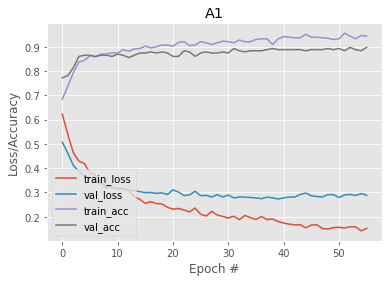

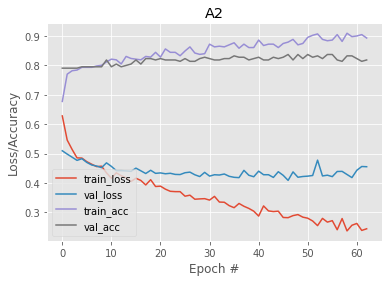

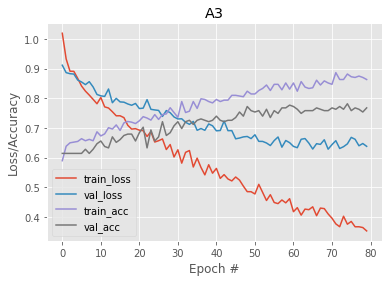

In [0]:
# Plot the training loss and accuracy
for model in hs.keys():
    tit = model.title()
    plt.style.use("ggplot")
    plt.figure()
    N = len(hs[model].history["loss"])
    plt.plot(np.arange(0, N), hs[model].history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), hs[model].history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), hs[model].history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), hs[model].history["val_accuracy"], label="val_acc")
    plt.title(tit)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(paths['results']+model+'.PNG')
    plt.show()
    # plt.ylim([0.5,1]) # Sets y axis limits

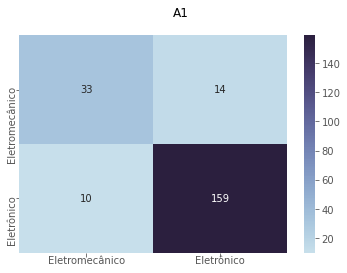

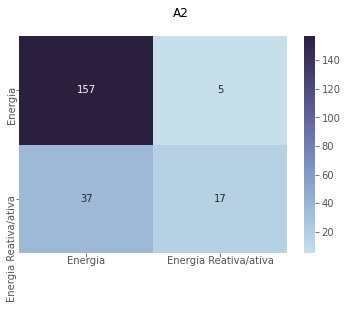

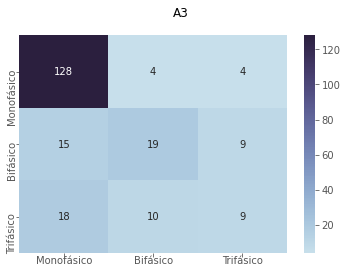

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

for model in models.keys():#k

    fg, ax = plt.subplots()
    y_test = test_data_lbl[model].argmax(axis=1)
    y_pred = predixs[model]
    
    labels = preds_lbls[model].lbls_names
    cm = confusion_matrix(y_test,y_pred)    
    
    cp = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
    f = sns.heatmap(cm, annot=True,fmt=".0f",cmap=cp,ax=ax)
    ax.set_xticklabels(labels,ha='center', va='center_baseline')
    ax.set_yticklabels(labels,ha='center', va='center_baseline')

    fg.suptitle(model)
    
    
    plt.show()

# **XAI**

In [0]:
# Sample idx
idx_tst = 18

# idx = idx_hit
max_evals = 5
model='A3'

## GradCam

In [0]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., newaxis]
    heatmap = np.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / reduce_max(heatmap)
    return heatmap.numpy()

In [0]:
db = pd.read_pickle(paths['results']+'db.pkl')

In [0]:
heatmaps={}
for model in models.keys():
    
    # Sample idx
    idx_hit = dbs[model][4][dbs[model][4].tst_lbl_argmax==predixs[model]].id_eq.iloc[idx_tst]
    idx_miss = dbs[model][4][dbs[model][4].tst_lbl_argmax!=predixs[model]].id_eq.iloc[idx_tst]

    idx = idx_hit
    img_path = db.path.loc[idx]
    md = models[model]
    last_conv_layer_name = [layer.name for layer in models[model].layers if 'conv' in layer.name][-1]
    img_dim = dbs[model][1].imgs_norm.iloc[0].shape[:2]#data[0].shape[:2]
    img_array = preprocess_input(get_img_array(img_path, size=img_dim))


    md.layers[-1].activation = None
    preds = md.predict(img_array)
    
    heatmap = make_gradcam_heatmap(img_array, md, last_conv_layer_name)
    heatmaps [model] = heatmap


In [0]:
def save_and_display_gradcam(img_path, heatmap, md, cam_path="cam.jpg", alpha=0.4):
    
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    superimposed_img.save(md+'/'+cam_path)

    display(Image(cam_path))

for model in models.keys():
#     data = dbs_full[model][dbs_full[model].subset=='test']
    
    idx_hit = dbs[model][4][dbs[model][4].tst_lbl_argmax==predixs[model]].id_eq.iloc[idx_tst]
    idx_miss = dbs[model][4][dbs[model][4].tst_lbl_argmax!=predixs[model]].id_eq.iloc[idx_tst]
    idx = idx_hit
    img_path = db.path.loc[idx]
    save_and_display_gradcam(img_path, heatmaps[model],paths['results']+model)

<IPython.core.display.Image object><IPython.core.display.Image object><IPython.core.display.Image object>

## Lime

In [0]:
idx_hit = dbs[model][4][dbs[model][4].tst_lbl_argmax==predixs[model]].id_eq.iloc[idx_tst]
idx_miss = dbs[model][4][dbs[model][4].tst_lbl_argmax!=predixs[model]].id_eq.iloc[idx_tst]
idx = idx_hit

In [0]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


In [0]:
# %%time
img = dbs[model][1][dbs[model][4].tst_lbl_argmax==predixs[model]].imgs_norm.iloc[idx_tst]
explanation = explainer.explain_instance(img.astype('double'), models[model].predict, top_labels=2, hide_color=0, num_samples=10)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


## XAI results

In [0]:
# Implement metrics to evaluate XAI, such as jaacrd distance, or any other, IOU, maybe segmentation would help